In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re

In [2]:
df = pd.read_csv("dataset/train.csv")
df['text'] = df['text'].astype("string")

In [3]:
def borrar_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def limpiar_simbolos(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def borrar_mentions(text):
    mention = re.compile(r'@\S+')
    return mention.sub(r'',text)

def borrar_hashtags(text):
    hashtag = re.compile(r'#\S+')
    return hashtag.sub(r'',text)

def borr_link_mentions(text):
    return borrar_url(borrar_hashtags(text))

def borrar_todo(text):
    return borrar_url(borrar_hashtags(borrar_mentions(text)))

def palabras(text):
    return len(text.split())


In [4]:
import warnings
warnings.filterwarnings('ignore')

df['?'] = df.apply(lambda x: borrar_todo(x.text).count('?'),axis=1)
df['!'] = df.apply(lambda x: borrar_todo(x.text).count('!'),axis=1)
df['@'] = df.apply(lambda x: x.text.count('@'),axis=1)
df['#'] = df.apply(lambda x: borrar_url(x.text).count('#'),axis=1)
df['http'] = df.apply(lambda x: 'http' in x.text,axis=1)
df['numeros'] = df.apply(lambda x: sum(c.isdigit() for c in borrar_todo(x.text)),axis=1)
df['palabras_sin_url'] = df.apply(lambda x: palabras(borrar_url(x.text)),axis=1)
df['tweet_length']=df['text'].str.len()
df['len_borrado']=df.apply(lambda x: len(borrar_todo(x.text)),axis=1)
df['palabras_borrado'] = df.apply(lambda x: palabras(borrar_todo(x.text)),axis=1)
df

,id,keyword,location,text,target,?,!,@,#,http,numeros,palabras_sin_url,tweet_length,len_borrado,palabras_borrado
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0,0,0,1,False,0,13,69,58,12
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0,0,False,0,7,38,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,0,0,0,False,0,22,133,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0,0,0,1,False,5,8,65,55,7
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0,0,0,2,False,0,16,88,71,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,0,0,0,0,True,0,10,83,61,10
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,0,0,2,0,False,0,20,125,101,18
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,1,0,0,0,True,8,7,65,43,7
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,0,0,0,0,False,0,19,137,137,19


Text(0.5, 1.0, 'Tweets')

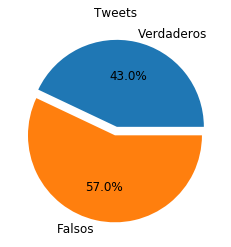

In [5]:
plt.pie(x=[df.groupby('target').size()[1],df.groupby('target').size()[0]],#invierto para coincidir colores
            autopct="%1.1f%%",
            explode=(0.05, 0.05),
            labels=("Verdaderos", "Falsos"),
            radius=1.0,
            textprops={"fontsize": 12}
       )
plt.title('Tweets')

Text(0, 0.5, 'Densidad')

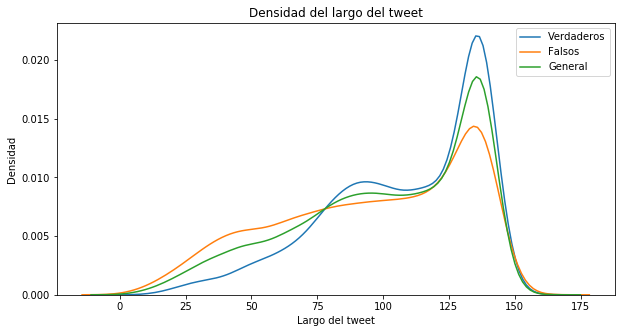

In [6]:
plt.figure(figsize=(10,5))
true_ones=df.loc[df.target==1]
false_ones=df.loc[df.target==0]
sns.kdeplot(data=true_ones['tweet_length'],label="Verdaderos" ,shade=False)
sns.kdeplot(data=false_ones['tweet_length'],label="Falsos" ,shade=False)
sns.kdeplot(data=df['tweet_length'],label="General" ,shade=False)
plt.title('Densidad del largo del tweet')
plt.xlabel('Largo del tweet')
plt.ylabel('Densidad')

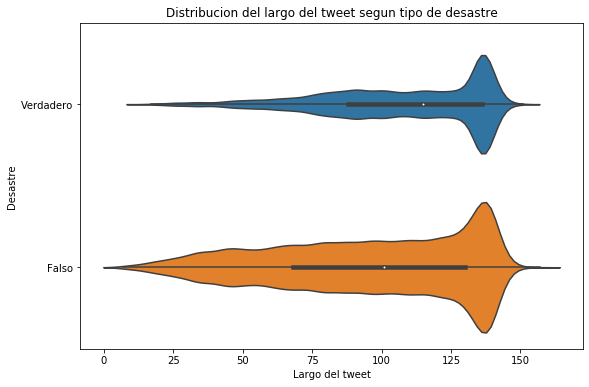

In [7]:
data=df[['target','text']]
data['text']=data.text.apply(len)
data.columns = ['Desastre','Largo del tweet']
data.Desastre=data.Desastre.astype('category')
data['Desastre']=data['Desastre'].replace([1,0],["Verdadero","Falso"])
plt.figure(figsize=(9,6))
plt.title('Distribucion del largo del tweet segun tipo de desastre')
sns.violinplot(x="Largo del tweet",y="Desastre",data=data, split=False, scale="count", bw=0.1)
data=None

In [8]:
def porcentuar(columna,inicio,rango,inc,titulo,x,y):
    datos=df.groupby([columna,'target']).size().to_frame().unstack().fillna(0).reset_index()
    porcentajes = pd.DataFrame()
    listaTrue=[]
    listaFalse=[]
    listaGrupo=[]
    cont=-1
    for i in range(inicio,rango,inc):
        cont=cont+1
        grupo = str(i) if inc==1 else (str(i)+" a "+str(i+inc-1))
        listaGrupo.append(grupo)
        listaFalse.append(datos.loc[datos[columna]>(i-1)].loc[datos[columna]<(i+inc)][0][0].sum())
        listaTrue.append(datos.loc[datos[columna]>(i-1)].loc[datos[columna]<(i+inc)][0][1].sum())
        if ((listaTrue[cont]+listaFalse[cont])<=10):#Si hay menos de 10 los descarto, no es contundente
            listaTrue.pop(cont)
            listaFalse.pop(cont)
            listaGrupo.pop(cont)
            cont=cont-1
            display(grupo+' eliminado por no ser relevante')



    porcentajes['truetemp']=listaTrue
    porcentajes['falsetemp']=listaFalse
    porcentajes['grupo']=listaGrupo
    porcentajes['true']=porcentajes['truetemp']*100/(porcentajes['truetemp']+porcentajes['falsetemp'])
    porcentajes['false']=porcentajes['falsetemp']*100/(porcentajes['truetemp']+porcentajes['falsetemp'])
    porcentajes=porcentajes.drop(['truetemp','falsetemp'],axis=1)
    porcentajes=porcentajes.set_index('grupo')
    if 'total' in titulo:
        ax=porcentajes.iloc[0].plot.pie(
            autopct="%1.1f%%",
            explode=(0.05, 0.05),
            labels=("Verdadero", "Falso"),
            radius=1.0,
            textprops={"fontsize": 12})
    else:
        ax=porcentajes.plot(kind='bar',stacked=True,figsize=(12,5))
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    ax.set_title(titulo)

'152 a 156 eliminado por no ser relevante'

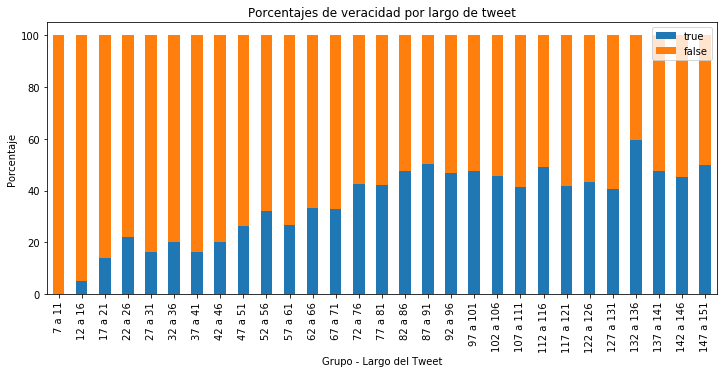

In [9]:
porcentuar('tweet_length',7,153,5,'Porcentajes de veracidad por largo de tweet','Grupo - Largo del Tweet','Porcentaje')

'147 a 151 eliminado por no ser relevante'

'152 a 156 eliminado por no ser relevante'

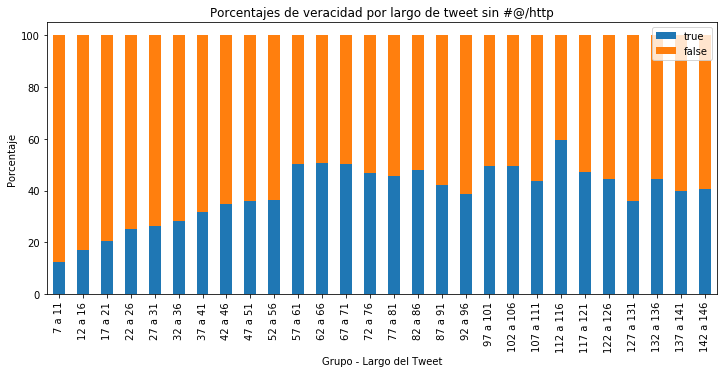

In [10]:
porcentuar('len_borrado',7,153,5,'Porcentajes de veracidad por largo de tweet sin #@/http','Grupo - Largo del Tweet','Porcentaje')

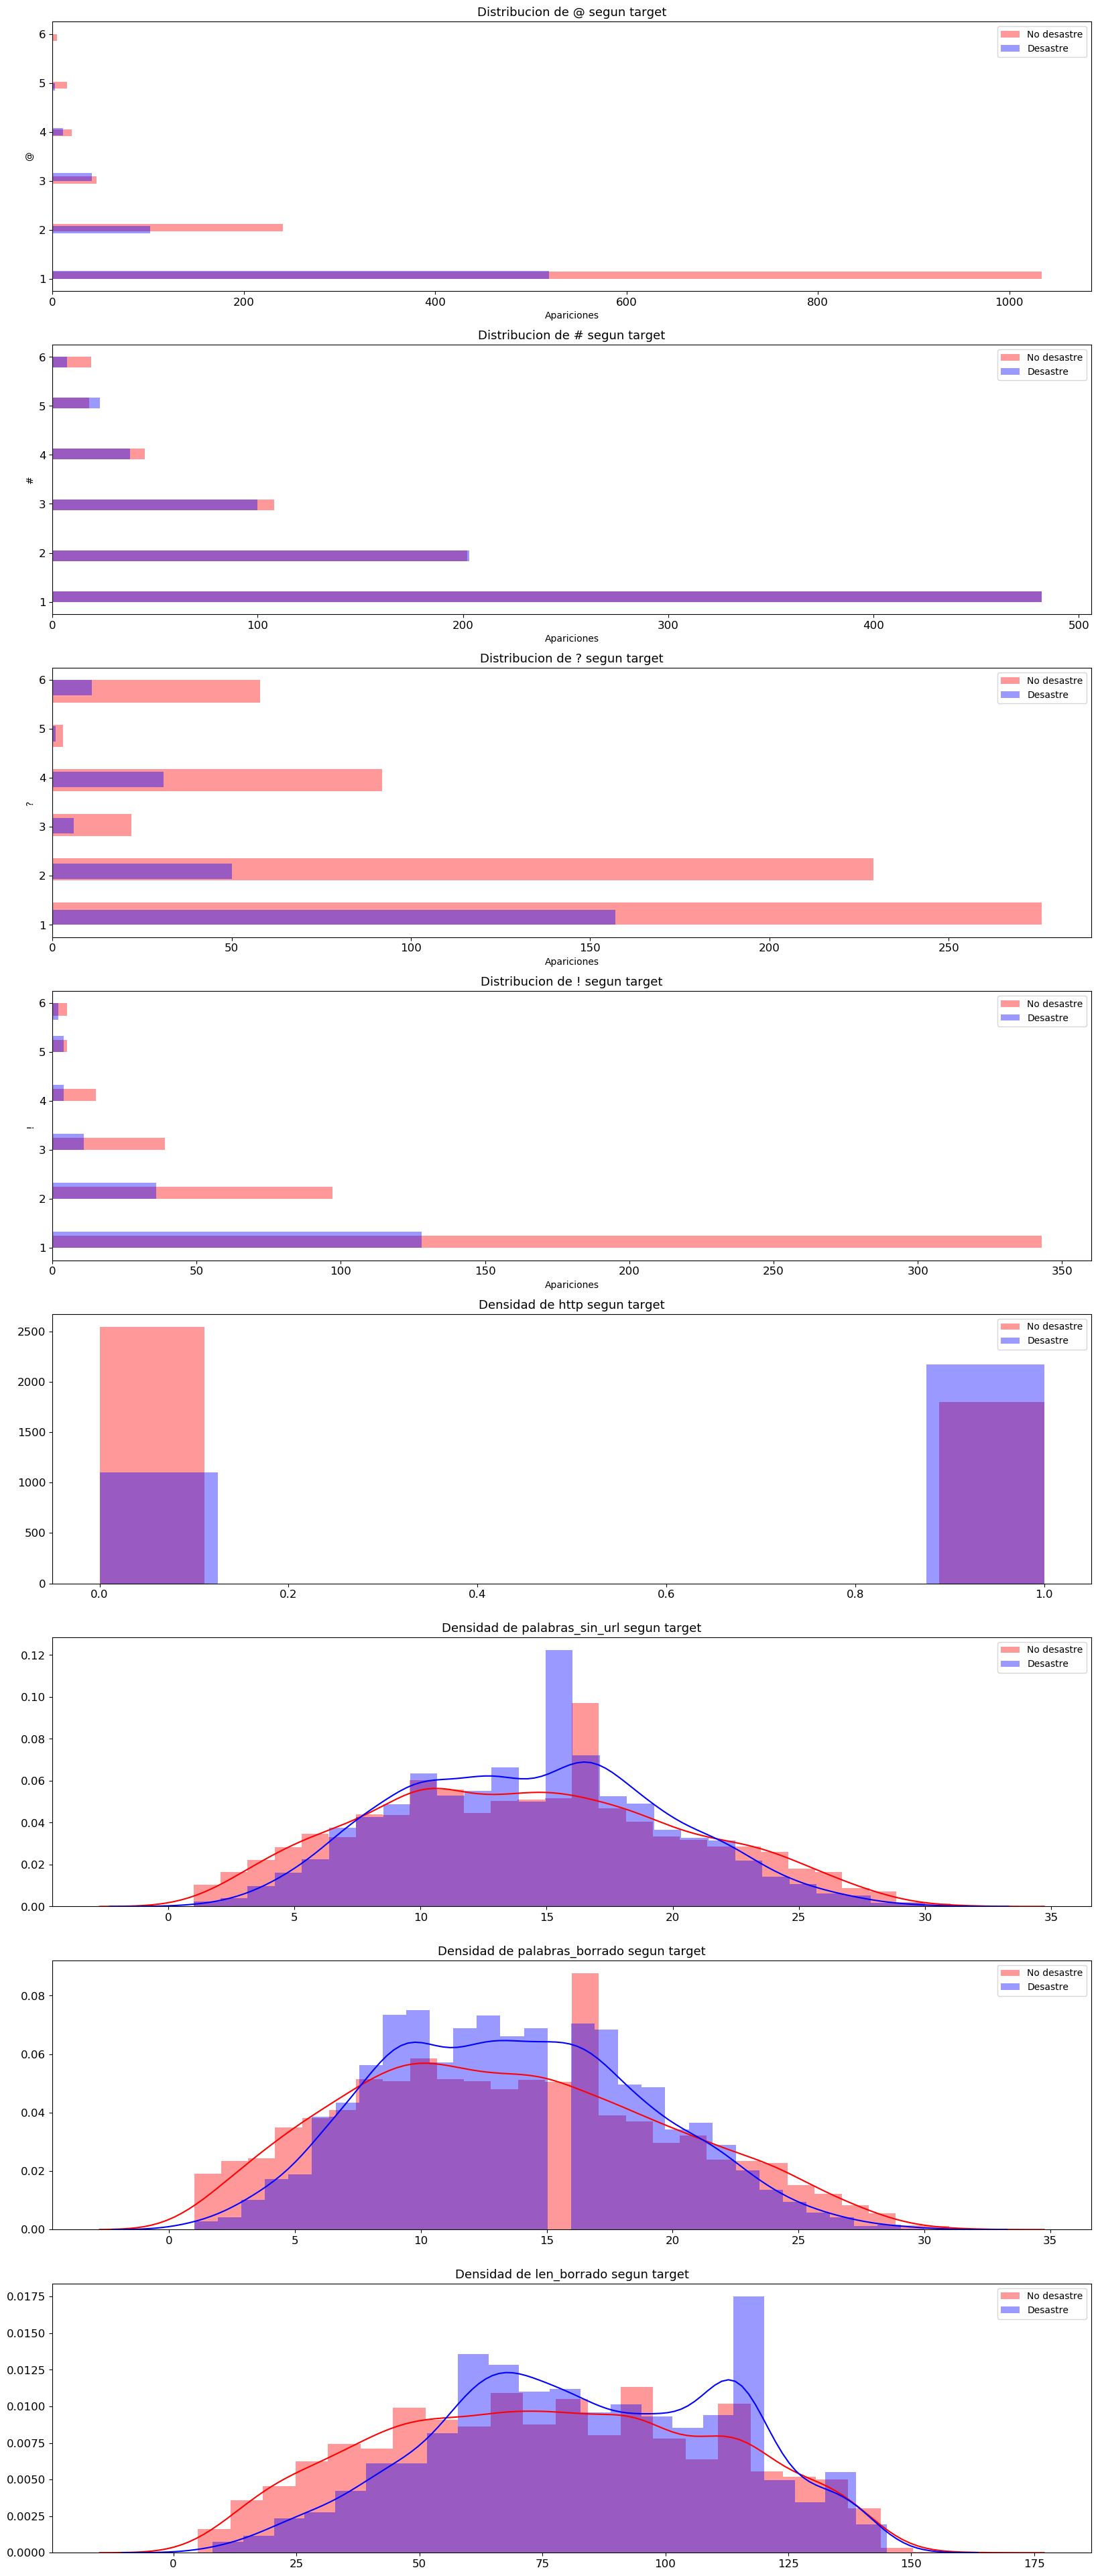

In [11]:
columnas = ['@','#','?','!','http','palabras_sin_url','palabras_borrado','len_borrado']

verdaderos = (df['target'] == 1)


fig, axes = plt.subplots(ncols=1, nrows=len(columnas), figsize=(20, 50), dpi=100)

for i, columna in enumerate(columnas):
    if columna in '@#?!':
        #Me interesan solo los mayores a 0
        sns.distplot(df.loc[~verdaderos].loc[df[columna]>0].loc[df[columna]<7][columna], label='No desastre', ax=axes[i], color='red', kde=0, vertical=True)
        sns.distplot(df.loc[verdaderos].loc[df[columna]>0].loc[df[columna]<7][columna], label='Desastre', ax=axes[i], color='blue',kde=0, vertical=True)
        xlabel="Apariciones"
        titulo="Distribucion"
    else:
        kde = columna!='http'
        xlabel=""
        titulo="Densidad"
        sns.distplot(df.loc[~verdaderos][columna], label='No desastre', ax=axes[i], color='red', kde=kde)
        sns.distplot(df.loc[verdaderos][columna], label='Desastre', ax=axes[i], color='blue',kde=kde)
        
    
    axes[i].set_xlabel(xlabel)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()
    
    axes[i].set_title(f'{titulo} de {columna} segun target', fontsize=13)

plt.show()

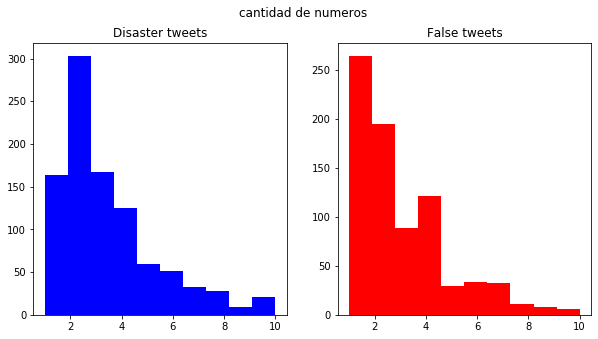

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
dfreal_graph2=df.loc[df['numeros'] > 0].loc[df['target']==1].loc[df['numeros'] < 11]['numeros']
ax1.hist(dfreal_graph2,color='blue',bins=10)
ax1.set_title('Disaster tweets')
dffalso_graph2=df[df['target']==0].loc[df['numeros'] < 11].loc[df['numeros'] > 0]['numeros']
ax2.hist(dffalso_graph2,color='red',bins=10)
ax2.set_title('False tweets')
fig.suptitle('cantidad de numeros')
plt.show()

None

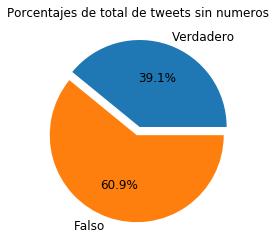

In [13]:
display(porcentuar('numeros',0,1,1,'Porcentajes de total de tweets sin numeros','',''))

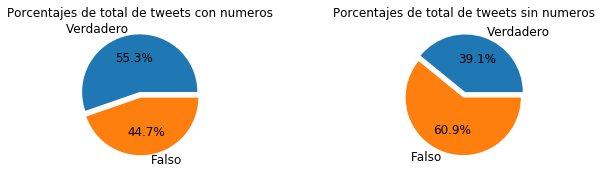

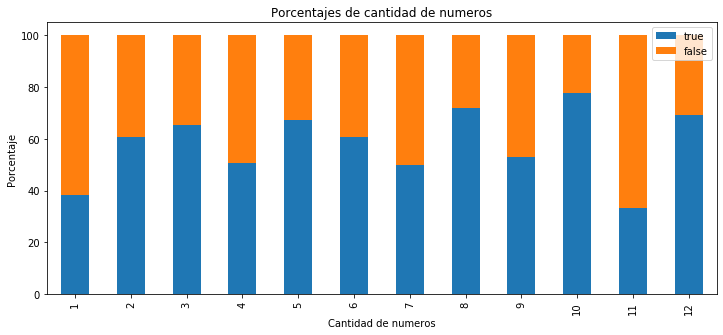

In [14]:
## NUMEROS 0303456
fig = plt.figure()
ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1=porcentuar('numeros',1,2000,2000,'Porcentajes de total de tweets con numeros','','')
ax2 = fig.add_axes([.75, 0, .5, .5], aspect=1)
ax2=porcentuar('numeros',0,1,1,'Porcentajes de total de tweets sin numeros','','')
plt.show()
porcentuar('numeros',1,13,1,'Porcentajes de cantidad de numeros','Cantidad de numeros','Porcentaje')

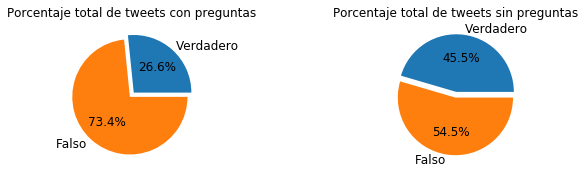

'5 eliminado por no ser relevante'

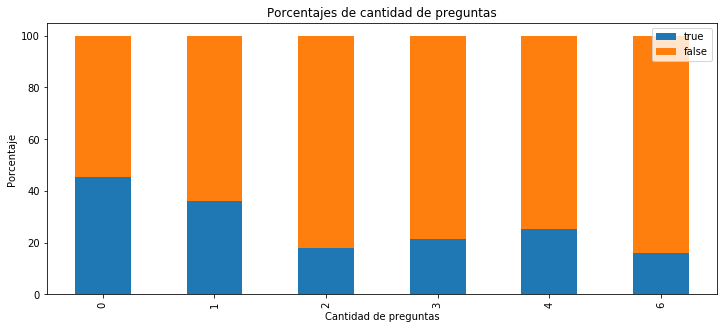

In [15]:
## PREGUNTONES ???
fig = plt.figure()
ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1=porcentuar('?',1,2000,2000,'Porcentaje total de tweets con preguntas','','')#tomo>0
ax2 = fig.add_axes([.75, 0, .5, .5], aspect=1)
ax2=porcentuar('?',0,1,1,'Porcentaje total de tweets sin preguntas','','')#tomo=0
plt.show()
porcentuar('?',0,7,1,'Porcentajes de cantidad de preguntas','Cantidad de preguntas','Porcentaje')

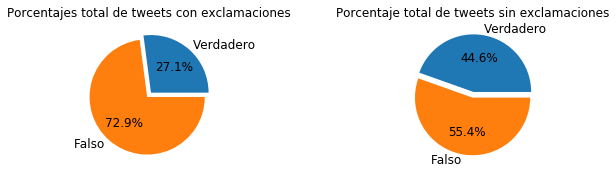

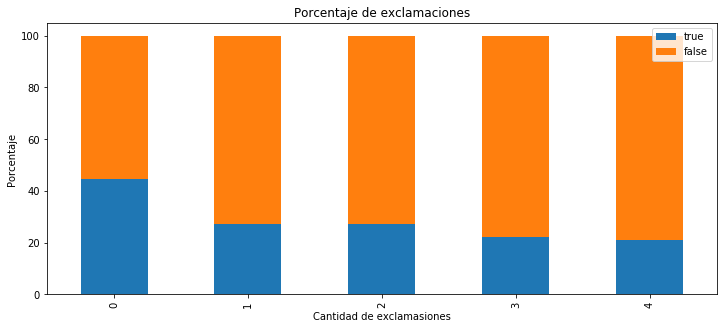

In [16]:
##EXCLAMACIONES !!!
fig = plt.figure()
ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1=porcentuar('!',1,2000,2000,'Porcentajes total de tweets con exclamaciones','','')#tomo>0
ax2 = fig.add_axes([.75, 0, .5, .5], aspect=1)
ax2=porcentuar('!',0,1,1,'Porcentaje total de tweets sin exclamaciones','','')#tomo=0
plt.show()
porcentuar('!',0,5,1,'Porcentaje de exclamaciones','Cantidad de exclamasiones','Porcentaje')

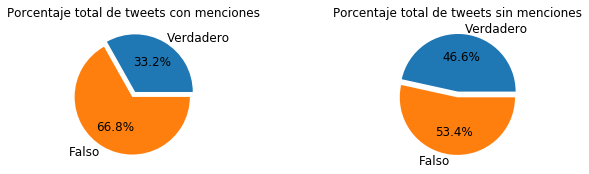

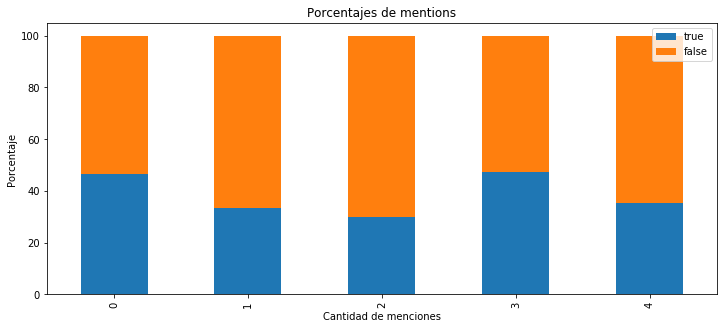

In [17]:
## MENTIONS @
fig = plt.figure()
ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1=porcentuar('@',1,2000,2000,'Porcentaje total de tweets con menciones','','')#tomo>0
ax2 = fig.add_axes([.75, 0, .5, .5], aspect=1)
ax2=porcentuar('@',0,1,1,'Porcentaje total de tweets sin menciones','','')#tomo=0
plt.show()
porcentuar('@',0,5,1,'Porcentajes de mentions','Cantidad de menciones','Porcentaje')

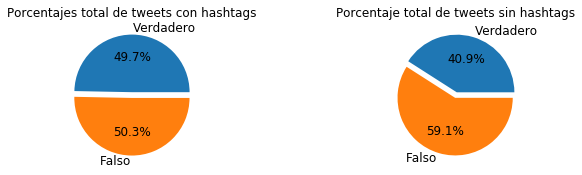

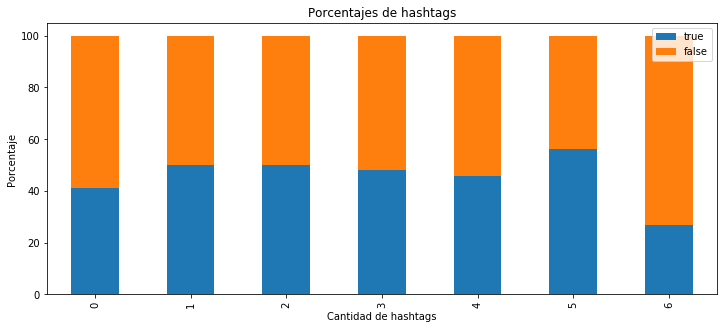

In [18]:
##HASHTAGS #
fig = plt.figure()
ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1=porcentuar('#',1,2000,2000,'Porcentajes total de tweets con hashtags','','')#tomo>0
ax2 = fig.add_axes([.75, 0, .5, .5], aspect=1)
ax2=porcentuar('#',0,1,1,'Porcentaje total de tweets sin hashtags','','')#tomo=0
plt.show()
porcentuar('#',0,7,1,'Porcentajes de hashtags','Cantidad de hashtags','Porcentaje')

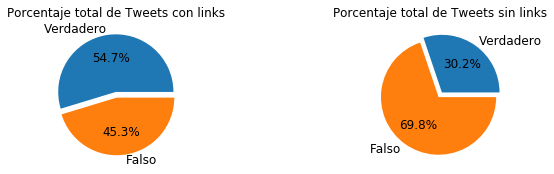

In [19]:
##LINKS
fig = plt.figure()
ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1=porcentuar('http',1,2,1,'Porcentaje total de Tweets con links','','')
ax2 = fig.add_axes([.75, 0, .5, .5], aspect=1)
ax2=porcentuar('http',0,1,1,'Porcentaje total de Tweets sin links','','')
plt.show()